# Bitcoin property hedging suggestion model using Diffusion Model and LSTM
---
In this notebook, we will implement a integrated machine learning model which can predict Bitcoin prices using a diffusion model for noise handling and an LSTM model for time series prediction. Finally, this model can give a suggestion to the investor to invest in long as well as short and control the fluctuation of the investment in 10 percents. The workflow includes data collection, preprocessing, model training, and generating investment advice.

## 1. Data Collection and Preprocessing
---
We will first load the Bitcoin price data and any relevant sentiment data, then preprocess it for use in our models.

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load Bitcoin price data
price_data_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Problem_Set_1.Peilin_Wu/refs/heads/main/Data/bitcoin0.csv'
price_df = pd.read_csv(price_data_url)

# Convert timestamps to date format
price_df['time'] = pd.to_datetime(price_df['time'], unit='ms')
price_df.set_index('time', inplace=True)

# Select required columns
price_df = price_df[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]

# Load market sentiment data (if available)
sentiment_data_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Problem_Set_1.Peilin_Wu/refs/heads/main/Data/google%20trends/geoMapbitcoin.csv'
sentiment_df = pd.read_csv(sentiment_data_url)

# Data cleaning and merging (if applicable)
# Uncomment and adjust the following lines based on the actual format of the sentiment data
# sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# sentiment_df.set_index('date', inplace=True)
# combined_df = price_df.join(sentiment_df, how='inner')

# For demonstration, we will use only the price data
combined_df = price_df.copy()

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df)

## 2. Noise Handling with Diffusion Model
---
We will define and train a diffusion model to handle noise in the data.



In [4]:
# 2. Noise Handling (Diffusion Model)
# Define the diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = scaled_data.shape[1]
diffusion_model = DiffusionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(diffusion_model.parameters(), lr=0.001)

# Prepare data
X = torch.tensor(scaled_data[:-1], dtype=torch.float32)
y = torch.tensor(scaled_data[1:], dtype=torch.float32)

# Train the diffusion model
epochs = 100
for epoch in range(epochs):
    diffusion_model.train()
    optimizer.zero_grad()
    outputs = diffusion_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Denoising
diffusion_model.eval()
with torch.no_grad():
    denoised_data = diffusion_model(X).numpy()

Epoch [10/100], Loss: 0.0562
Epoch [20/100], Loss: 0.0201
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0060
Epoch [50/100], Loss: 0.0029
Epoch [60/100], Loss: 0.0023
Epoch [70/100], Loss: 0.0019
Epoch [80/100], Loss: 0.0017
Epoch [90/100], Loss: 0.0017
Epoch [100/100], Loss: 0.0016


## 3. Time Series Prediction with LSTM
---
Next, we will define and train an LSTM model to predict future Bitcoin prices based on the denoised data.

In [5]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Set parameters for LSTM
input_size = input_dim
hidden_size = 50
num_layers = 2
output_size = input_dim
sequence_length = 30

# Prepare LSTM input data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_lstm, y_lstm = create_sequences(denoised_data, sequence_length)
X_lstm = torch.tensor(X_lstm, dtype=torch.float32)
y_lstm = torch.tensor(y_lstm, dtype=torch.float32)

# Initialize and train the LSTM model
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs = 50
for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(X_lstm)
    loss = criterion(outputs, y_lstm)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Make predictions
lstm_model.eval()
with torch.no_grad():
    last_sequence = X_lstm[-1].unsqueeze(0)  # Add batch dimension
    predictions = lstm_model(last_sequence).numpy()

# Print predicted values
print("Predicted values (scaled):", predictions)


Epoch [10/50], Loss: 0.0970
Epoch [20/50], Loss: 0.0428
Epoch [30/50], Loss: 0.0163
Epoch [40/50], Loss: 0.0054
Epoch [50/50], Loss: 0.0051
Predicted values (scaled): [[0.9314332  0.83419764 0.8310585  0.9028925  0.05489433 0.18674852]]


## 4. Inverse Normalization and Investment Advice
---
Finally, we will inverse normalize the predicted values and generate investment advice based on the predictions.

In [7]:

# Print predicted values
print("Predicted values (scaled):", predictions)

# Inverse normalize the predicted values to actual prices
denormalized_predictions = scaler.inverse_transform(predictions)
print("Predicted values (denormalized):", denormalized_predictions)

# Generate investment advice
latest_close_price = scaler.inverse_transform([scaled_data[-1]])[0][0]
predicted_close_price = denormalized_predictions[0][0]

print(f"Latest Close Price: {latest_close_price:.2f}")
print(f"Predicted Close Price: {predicted_close_price:.2f}")

if predicted_close_price > latest_close_price * 1.02:  # Suggest buying if price is expected to rise by more than 2%
    print("Investment Advice: Buy (Price is expected to rise significantly)")
elif predicted_close_price < latest_close_price * 0.98:  # Suggest selling if price is expected to fall by more than 2%
    print("Investment Advice: Sell (Price is expected to fall significantly)")
else:
    print("Investment Advice: Hold (Price movement is within normal range)")

Predicted values (scaled): [[0.9314332  0.83419764 0.8310585  0.9028925  0.05489433 0.18674852]]
Predicted values (denormalized): [[7.5367969e+04 6.9515102e+04 6.6190695e+04 7.0761039e+04 8.0462203e+04
  5.6915441e+09]]
Latest Close Price: 79754.55
Predicted Close Price: 75367.97
Investment Advice: Sell (Price is expected to fall significantly)


## 5. Generate Saliency Map
---
We will generate a saliency map to visualize the importance of each feature in the LSTM model's predictions

Epoch [10/50], Loss: 0.1215
Epoch [20/50], Loss: 0.0365
Epoch [30/50], Loss: 0.0269
Epoch [40/50], Loss: 0.0123
Epoch [50/50], Loss: 0.0063


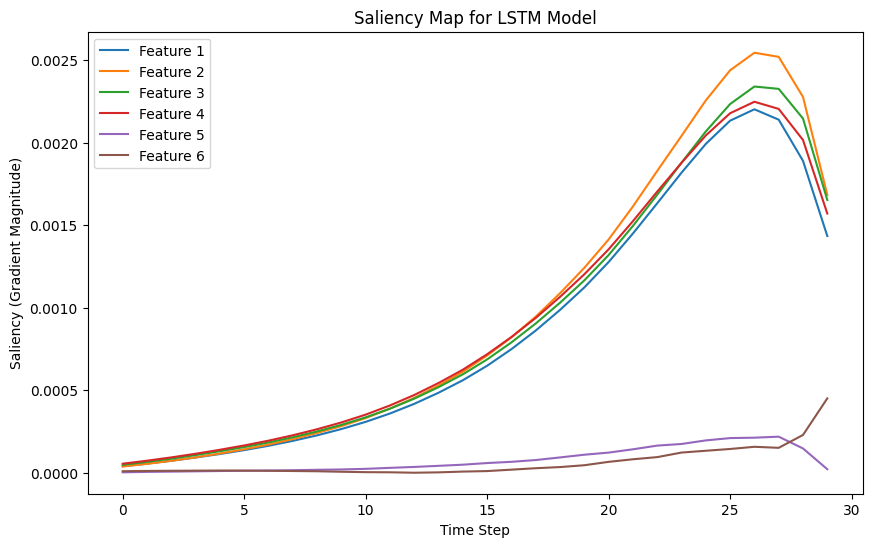

Predicted values (scaled): [[0.7926096  0.8417256  0.8565564  0.9065462  0.06985234 0.13147238]]
Predicted values (denormalized): [[6.6486680e+04 6.9995250e+04 6.7746445e+04 7.0983523e+04 9.9108836e+04
  4.1087823e+09]]


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model as before
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output of the last time step
        return out

# Generate Saliency Map
def generate_saliency_map(model, input_data, target):
    # Set model to evaluation mode
    model.eval()

    # Set requires_grad=True to calculate the gradient with respect to the input
    input_data.requires_grad_()

    # Perform forward pass
    output = model(input_data)

    # Compute loss (using Mean Squared Error loss for regression)
    loss = criterion(output, target)

    # Backward pass to compute gradients
    loss.backward()

    # Get the gradient of the input data
    saliency = input_data.grad.abs()  # Take the absolute value of the gradient

    return saliency

# Example sequence length and feature number (as defined in your model)
sequence_length = 30
input_size = input_dim
hidden_size = 50
num_layers = 2
output_size = input_dim

# Prepare the input data (using denoised_data from previous model)
X_lstm, y_lstm = create_sequences(denoised_data, sequence_length)
X_lstm = torch.tensor(X_lstm, dtype=torch.float32)
y_lstm = torch.tensor(y_lstm, dtype=torch.float32)

# Initialize LSTM model
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model as usual (same as your code)

epochs = 50
for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(X_lstm)
    loss = criterion(outputs, y_lstm)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Now generate the saliency map for the last sequence in the dataset
lstm_model.eval()

# Select the last sequence of data for saliency analysis
last_sequence = X_lstm[-1].unsqueeze(0)  # Add batch dimension
target = y_lstm[-1].unsqueeze(0)  # Corresponding target

# Generate the saliency map
saliency = generate_saliency_map(lstm_model, last_sequence, target)

# Visualize the saliency map (plot the gradient magnitudes for each time step)
saliency = saliency.squeeze(0).detach().numpy()  # Remove the batch dimension and convert to NumPy

# Plot the saliency map for each feature (for the last sequence)
plt.figure(figsize=(10, 6))
for i in range(input_dim):
    plt.plot(saliency[:, i], label=f'Feature {i+1}')
plt.title("Saliency Map for LSTM Model")
plt.xlabel("Time Step")
plt.ylabel("Saliency (Gradient Magnitude)")
plt.legend()
plt.show()

# Now make predictions using the last sequence
with torch.no_grad():
    predictions = lstm_model(last_sequence).numpy()

# Print predicted values
print("Predicted values (scaled):", predictions)

# Inverse normalize the predicted values to actual prices
denormalized_predictions = scaler.inverse_transform(predictions)
print("Predicted values (denormalized):", denormalized_predictions)


## 6. Visualization and Analysis
---
### a. Inverse Scaling of Predictions
This line of code reverses the normalization applied earlier, transforming the predicted values from the normalized range (0 to 1) back into the actual Bitcoin prices. This is done because the data was previously scaled using MinMaxScaler, so the predicted values are in a normalized state. The inverse_transform function restores these values to the original scale.

In [9]:
denormalized_predictions = scaler.inverse_transform(predictions)


### b. Original Data Time Series Plot
---
This code generates a time series plot for the original Bitcoin price data. Key steps include:

price_df['close'] extracts the closing price of Bitcoin.\
plt.plot plots this data with time on the x-axis and the price on the y-axis.\
plt.legend adds a label for the "Close Price" line in the chart.\
plt.show displays the chart.\
This chart helps us visualize the actual trends in Bitcoin's price over time.

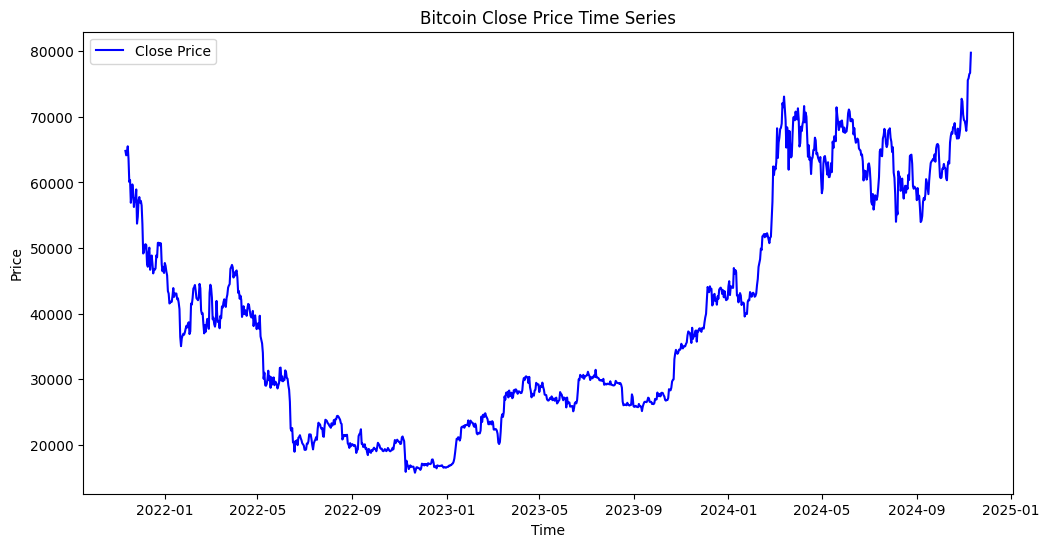

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(price_df.index, price_df['close'], label='Close Price', color='blue')
plt.title('Bitcoin Close Price Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### c. Denoised Data vs. Original Data
---
This section compares the denoised data with the original data. The denoised data is obtained through a diffusion model (as mentioned in your code). Here are the steps:

scaled_data[:plot_length, 0] represents the scaled original Bitcoin closing price.\
denoised_data[:plot_length, 0] represents the denoised version of the data.
plt.plot draws both the original and denoised data on the same graph for comparison.\
The plot shows how well the diffusion model has filtered the noise from the data.\ It also allows us to visually inspect how effective the denoising process was compared to the original data.

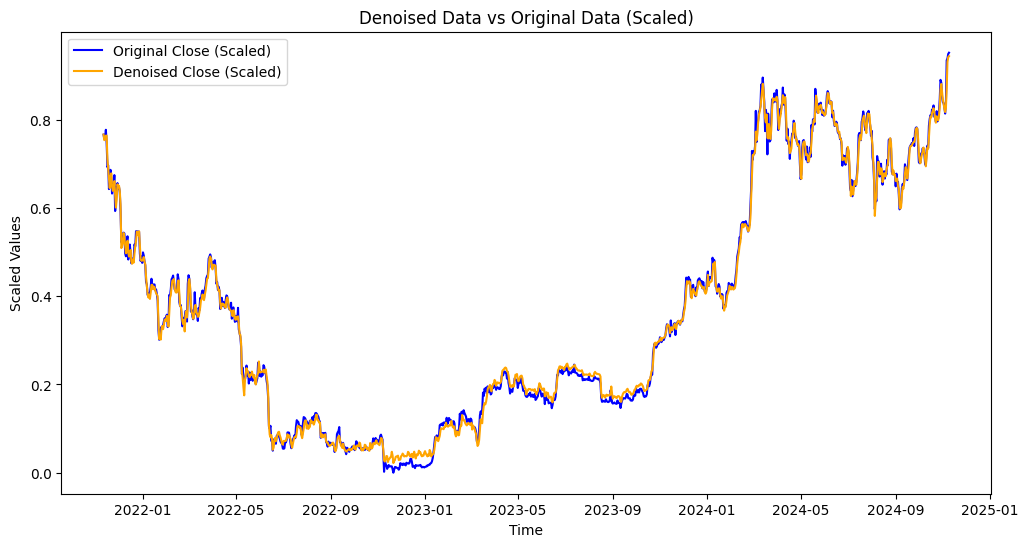

In [11]:
plot_length = min(len(price_df), len(denoised_data))  # Use the minimum length
plt.figure(figsize=(12, 6))
plt.plot(price_df.index[:plot_length], scaled_data[:plot_length, 0], label='Original Close (Scaled)', color='blue')
plt.plot(price_df.index[:plot_length], denoised_data[:plot_length, 0], label='Denoised Close (Scaled)', color='orange')
plt.title('Denoised Data vs Original Data (Scaled)')
plt.xlabel('Time')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()


### d. Prediction Error Distribution
---
This part visualizes the distribution of prediction errors:

y_lstm.numpy() converts the true values (actual Bitcoin prices) from a PyTorch tensor to a NumPy array.\
scaler.inverse_transform(y_lstm.numpy())[:, 0] reverses the normalization of the true values.\
scaler.inverse_transform(predictions)[:, 0] reverses the normalization of the predicted values.\
errors is calculated by subtracting the predicted values from the actual values (both denormalized).\
plt.hist(errors, bins=30) creates a histogram to show the distribution of prediction errors with 30 bins.\
plt.show displays the histogram.\
The histogram helps assess the performance of the prediction model by showing the error distribution. If the errors are normally d[链接文字](https://)istributed around zero, it indicates that the model's predictions are reasonably accurate and unbiased.

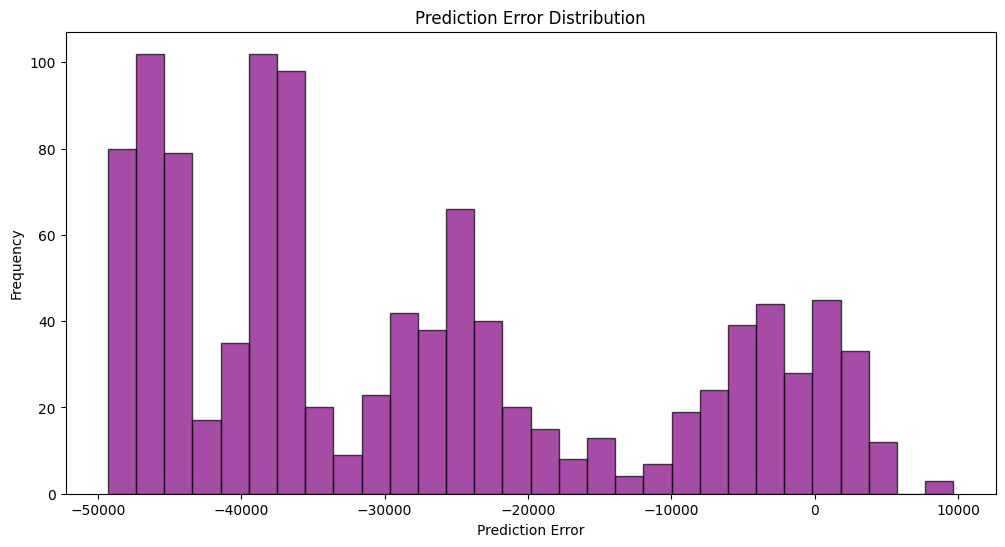

In [12]:
errors = scaler.inverse_transform(y_lstm.numpy())[:, 0] - scaler.inverse_transform(predictions)[:, 0]
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()
